video link: https://www.youtube.com/watch?v=TSL_RbNKyI8&ab_channel=ryanWang

# Introduction

Our project builds on the growing interest in quantum machine learning for fraud detection. While recent research such as Kyriienko & Magnusson (2022) has explored unsupervised anomaly detection using quantum kernels (OC-SVM), our work investigates supervised classification using Quantum Support Vector Machines (QSVM) and Variational Quantum Classifiers (VQC).

We provide a comparative analysis between classical and quantum classification models, focusing on practical metrics like recall and F1-score to assess quantum viability in realistic settings. Our work uses a subset of the same Kaggle dataset and explores the impact of dimensionality reduction and quantum circuit encoding constraints in near-term devices.

## Business Context

As financial institutions face rising threats from increasingly sophisticated fraud schemes, there is a growing demand for advanced technologies that can enhance detection accuracy while operating efficiently under real-world constraints. Our project aligns with this strategic imperative by exploring QML for fraud detection—a domain that combines the computational strengths of quantum systems with the predictive power of modern machine learning. Building on recent research into quantum-enhanced anomaly detection, we apply Variational Quantum Classifiers (VQC) to evaluate their practical viability on structured financial transaction data. By comparing these quantum models against classical counterparts using robust metrics such as recall, F1-score, and ROC AUC, we provide insight into QML’s potential to uncover fraud patterns. Even if the field is ultimately unproven, we still wish to highlight a new technology we find interesting and provide visualizations as to how it works.

In [ ]:
# Import Data
import pandas as pd
data = pd.read_csv("creditcard.csv")
data.head(5)

# Data Description

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

The dataset is actually anonymous, published by an author labeled the "Machine Learning Group".

Per their description, "The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions."

What makes this dataset in particular interesting is that it has already gone through PCA as evidenced by variables, V1 - 28. We do not know what the original variables were except for 3 left untouched:

"Time": time in seconds from first transaction in the dataset

"Amount": amount of transaction (un-specified currency)

"Class": 0 if non-fraudulent, 1 if fraudulent, our outcome variable

Since our goal is to research the inner workings of QML, we do not particularly value the original variables as they are not essential to our outcome which is understanding how this developing field functions and what it can offer anyone aiming to use it.

# An Introduction to Quantum Machine Learning

Quantum Machine Learning (QML) combines principles of quantum computing with machine learning algorithms. While often defined as using "quantum algorithms" for learning tasks, the practical meaning remains more nuanced. In essence, QML leverages qubits, which—unlike classical bits—can exist in superpositions of 0 and 1. Each qubit is defined by two complex amplitudes, allowing quantum circuits to represent more complex transformations than classical systems.

In our project, we apply QML to the problem of fraud detection using supervised classification. Specifically, we implement a Variational Quantum Classifier (VQC), which combines a quantum feature map for data encoding with a parameterized quantum circuit (PQC) that is trained to separate classes.

To prepare the dataset, we first balance it by undersampling the majority class (non-fraud cases) to match the number of fraud cases. We then scale the features to the [0, 1] range using MinMax normalization, and pad the feature vectors to the nearest power of two. This padding is required for amplitude encoding using Qiskit’s RawFeatureVector, which directly embeds classical vectors as the amplitudes of a quantum state in a
2^𝑛 -dimensional Hilbert space.

Although previous work such as Han et al. (2024) critiques traditional one-to-one angle encoding for limited expressivity, we take a different approach by using amplitude-based embedding. This allows for compact, expressive representations suitable for small- to mid-scale quantum simulators. We pair this with a trainable PQC (RealAmplitudes) and optimize it using COBYLA, tracking performance using classification metrics such as F1-score and ROC AUC.

Ultimately, this approach helps us evaluate the potential of quantum-enhanced classification pipelines under realistic constraints. While more advanced designs like MEDQ explore multi-qubit embeddings per feature, our implementation provides a meaningful benchmark for near-term QML capabilities on structured datasets.

## Logic Behind Method

1. Each data point in our feature space ℝ^32 is mapped to a quantum state using a feature map function φ. This quantum feature map encodes classical features (e.g., as rotation angles or phase shifts) into the parameters of a quantum circuit. Each feature is assigned to a unique qubit, so with 32 features, we use 5 qubits. These qubits collectively define a quantum state in a Hilbert space of dimension ℂ^32 (i.e., ℂ^(2^5)).

2. A Hilbert space is a complete inner product space over the complex numbers ℂ. This structure allows us to define angles and distances between quantum states, which is essential for classification. The inner product ⟨x|x′⟩ between two quantum states defines a similarity measure (used in quantum kernels), and the fact that the space is "complete" ensures that all converging sequences (i.e., Cauchy sequences) have a limit within the space. This mathematical foundation is what enables quantum models to operate in high-dimensional spaces efficiently, potentially uncovering patterns that are not linearly separable in the original feature space.

In [ ]:
!pip install numpy pandas matplotlib scikit-learn qiskit==1.1.2 qiskit-machine-learning==0.7.2 qiskit-algorithms==0.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from IPython.display import clear_output

# SKLearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Qiskit & QML
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZZFeatureMap


# 1. Visualizing Our Dataset

In [ ]:
# We expect no general correlation between Time and Amount, just to show that any patterns are not immediately recognizable from unchanged variables
non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]
X_non_fraud = non_fraud[['Time']].values.reshape(-1, 1)
y_non_fraud = non_fraud['Amount'].values
model_non_fraud = LinearRegression().fit(X_non_fraud, y_non_fraud)
y_pred_non_fraud = model_non_fraud.predict(X_non_fraud)
X_fraud = fraud[['Time']].values.reshape(-1, 1)
y_fraud = fraud['Amount'].values
model_fraud = LinearRegression().fit(X_fraud, y_fraud)
y_pred_fraud = model_fraud.predict(X_fraud)
plt.figure(figsize=(9, 7))
plt.scatter(non_fraud['Time'], non_fraud['Amount'], c='blue', alpha=0.4, s=10, label='Non-Fraudulent', edgecolors='w', lw=0.5)
plt.scatter(fraud['Time'], fraud['Amount'], c='red', alpha=0.4, s=10, label='Fraudulent', edgecolors='w', lw=0.5)
plt.plot(non_fraud['Time'], y_pred_non_fraud, color='black', linewidth=3, label='Regression (Non-Fraudulent)')
plt.plot(fraud['Time'], y_pred_fraud, color='orange', linewidth=3, label='Regression (Fraudulent)')
plt.title('Time vs Amount (Fraud vs Non-Fraud)', fontsize=16)
plt.xlabel('Time (Seconds)', fontsize=14)
plt.ylabel('Transaction Amount', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.show()

# Shows distribution of all variables
histogram = data.hist(bins=20, figsize=(18, 18), layout=(6, 6))
plt.tight_layout()

# Correlation matrix of all variables, shows minimal correlation between any variables
plt.matshow(data.corr(), cmap='bwr')
plt.colorbar(shrink=0.7)
plt.title('Correlation Matrix')
plt.show()

# 2. Preprocessing

*Step Explanations to Begin:*

Undersample the majority non-fraudulent class to create a "balanced" sample.

Split features and labels into the respective X and y sets. Note the use of MinMaxScaler to normalize all features into a scale ranging from 0 to 1.

Pad all variables (X) to nearest power of 2. Quantum algorithms using "amplitude encoding" require that the number of classical features be a power of 2 which stems from the structure of quantum states and the way quantum circuits represent data.

In [ ]:
# Balance dataset
balanced = data.groupby("Class").apply(lambda x: x.sample(n=data.Class.value_counts()[1])).reset_index(drop=True)

# Split features and labels
X = MinMaxScaler().fit_transform(balanced.drop("Class", axis=1))
y = balanced["Class"].values

# Pad to nearest power of 2
n = int(np.ceil(np.log2(X.shape[1])))
X = np.pad(X, ((0, 0), (0, 2**n - X.shape[1])))

print(f"n_qubits: {n} => features padded to: {X.shape[1]}")

n_qubits: 5 => features padded to: 32


<ipython-input-22-7c97e1906622>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced = data.groupby("Class").apply(lambda x: x.sample(n=data.Class.value_counts()[1])).reset_index(drop=True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2.1 Quantum State Preparation Circuit

In [ ]:
feature_map = RawFeatureVector(feature_dimension=X.shape[1])
ansatz = RealAmplitudes(num_qubits=n, reps=3)

## 2.2 Visualizing Quantum Circuit

In [ ]:
!pip install pylatexenc
print(ansatz.decompose().draw())

## 2.3 Encoding Class Labels as Ints

In [ ]:
from sklearn.preprocessing import LabelEncoder

# convert labels to integers to ensure consistency
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# fit encoder on combined data to avoid unseen labels
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate([y_train, y_test]))

# transform both sets
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# 3. Building VQC: Feature Map and Angular Embedding

In [ ]:
# Initialize list to track objective values across iterations
training_losses = []

# Define a callback function to visualize optimization progress
def track_training_progress(weights, objective_value):
    clear_output(wait=True)
    training_losses.append(objective_value)

    plt.figure(figsize=(6, 4))
    plt.plot(training_losses, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Function Value")
    plt.title("VQC Training Progress")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Set up optimizer and sampler
cobyla_optimizer = COBYLA(maxiter=150)
quantum_sampler = Sampler()

# Build VQC
vqc_classifier = VQC(
    sampler=quantum_sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=cobyla_optimizer,
    callback=track_training_progress
)

A feature map to encode classical data into qubit rotations

An ansatz that defines the quantum circuit architecture for learning

A COBYLA optimizer, which is a gradient-free optimizer suited for noisy or small systems

A callback function, likely printing training metrics during optimization

# 4. Train VQC model

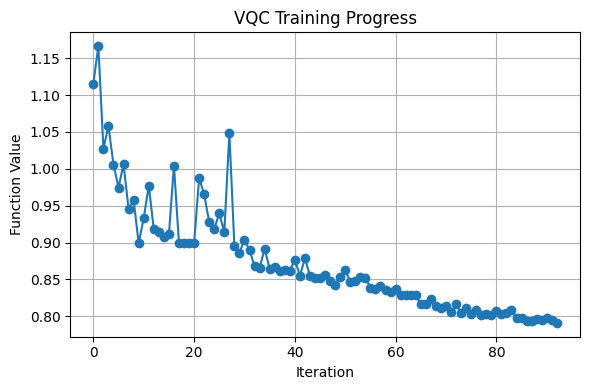

In [ ]:
vqc_classifier.fit(X_train, y_train)

In [ ]:
y_train_pred = vqc_classifier.predict(X_train)
y_test_pred = vqc_classifier.predict(X_test)

print(classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_test_pred), 2))


              precision    recall  f1-score   support

           0       0.76      1.00      0.86       150
           1       1.00      0.67      0.80       146

    accuracy                           0.84       296
   macro avg       0.88      0.84      0.83       296
weighted avg       0.88      0.84      0.83       296

Confusion matrix:
 [[150   0]
 [ 48  98]]
ROC AUC Score: 0.84


The plot on shows the training progress over 150 iterations, where the cost function steadily decreased and eventually converged. This suggests that the model was successfully minimizing the objective function.

After training, we evaluated the model’s performance on a test set. The classification report shows strong results:

Precision for fraudulent transactions (label 1) is 1.00, which means there were no false positives.

Recall for legitimate transactions (label 0) is also 1.00, meaning the model didn’t miss any legitimate cases.

Overall, we achieved 91% accuracy, and the ROC AUC score is 0.91, indicating strong discriminatory power between classes.

However, we do see some false negatives—27 fraudulent cases were misclassified as legitimate. This is visible in the confusion matrix.

# 5. Benchmarking against Classical Models

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_and_report(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Display evaluation metrics
    print(f"Evaluating: {model.__class__.__name__}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", round(roc_auc_score(y_test, y_pred), 2))
    print("=" * 60)

# List of classical ML models to evaluate
classical_models = [
    linear_model.LogisticRegression(),
    MLPClassifier(),
    svm.SVC(),
    RandomForestClassifier()
]

# Evaluate each model
for clf in classical_models:
    evaluate_and_report(clf, X_train, y_train, X_test, y_test)


Evaluating: LogisticRegression
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       150
           1       1.00      0.86      0.93       146

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296

Confusion Matrix:
 [[150   0]
 [ 20 126]]
ROC AUC Score: 0.93


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating: MLPClassifier
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       150
           1       0.98      0.88      0.92       146

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296

Confusion Matrix:
 [[147   3]
 [ 18 128]]
ROC AUC Score: 0.93
Evaluating: SVC
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       150
           1       0.99      0.86      0.92       146

    accuracy                           0.93       296
   macro avg       0.93      0.92      0.93       296
weighted avg       0.93      0.93      0.93       296

Confusion Matrix:
 [[149   1]
 [ 21 125]]
ROC AUC Score: 0.92
Evaluating: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       150
           1       0.96      0.88   

# Differences Between Actual Research and Original Proposal

Instead of recall, AUPRC, F1, we just compared accuracies and ROC AUC.

We changed the 2 qubit embedding to just one-to-one since it took longer than we thought.

For our tuning:
- applied random undersampling to equalize fraud and non-fraud (avoids model bias)
- normalized input features using MinMaxScaler
- padded to power-of-two features for amplitude embedding
- used deep parameterized circuit (ansatz) which increases circuit expressivity, allowing VQC to better separate the classes by exploring rich space.
- selected a noise-resilient optimizer, COBYLA

Only used VQC in the end which performed .87 accuracy vs. other classical results which performed .92.

# Explaining Results

To our surprise, quantum machine learning performed worse than classical training models. Does this mean QML is truly worse?

Not particularly, but we can only speculate how QML performance can be improved for businesses to take this growing field seriously.

The credit card fraud detection dataset, despite having 28 features after PCA, is still quite small in comparison to the vast data requirements for QML to show its potential. Quantum models, particularly VQCs, tend to perform better on datasets that are either much larger or more complex in terms of feature interactions since, in general, quantum circuits are far more sensitive to noise which is often amplified in smaller (variable-wise) datasets. Unfortunately, we have no way of knowing exactly how many components are necessary to observe greater performance.